<a href="https://colab.research.google.com/github/Indian-otaku/Introduction_To_PyTorch/blob/main/cnn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import necessary modules

In [72]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer

## Device agnostic code

In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Preparing data

In [74]:
# Downloading the dataset
train_data = FashionMNIST(root='data',
                          train=True,
                          transform=ToTensor(),
                          target_transform=None,
                          download=True)
test_data = FashionMNIST(root='data',
                          train=False,
                          transform=ToTensor(),
                          target_transform=None,
                          download=True)

In [75]:
# Turning datasets into dataloaders
BATCH_SIZE = 32
train_data_loader = DataLoader(dataset=train_data,
                               batch_size=BATCH_SIZE,
                               shuffle=True)
test_data_loader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False)

In [76]:
train_data_loader.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

## Creating the model

In [77]:
from torch.nn.modules.pooling import MaxPool2d
class FMNISTCNNModel1(nn.Module):
    def __init__(self, input_shape, hidden_nodes, output_shape):
        super().__init__()
        self.convbatch1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_nodes,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=True,
                      device=device,
                      dtype=torch.float),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_nodes,
                      out_channels=hidden_nodes,
                      kernel_size=(3, 3), # Same as giving the value 3
                      stride=1,
                      padding=1,
                      bias=True,
                      device=device,
                      dtype=torch.float),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.convbatch2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_nodes,
                      out_channels=hidden_nodes,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=True,
                      device=device,
                      dtype=torch.float),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_nodes,
                      out_channels=hidden_nodes,
                      kernel_size=3,
                      stride=1,
                      padding=1,
                      bias=True,
                      device=device,
                      dtype=torch.float),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_nodes*7*7,
                      out_features=hidden_nodes,
                      bias=True,
                      device=device,
                      dtype=torch.float),
            nn.ReLU(),
            nn.Linear(in_features=hidden_nodes,
                      out_features=output_shape,
                      bias=True,
                      device=device,
                      dtype=torch.float)
        )
    def forward(self, x: torch.Tensor)-> torch.Tensor:
        return self.layer(self.convbatch2(self.convbatch1(x)))


In [78]:
model1 = FMNISTCNNModel1(input_shape=1,
                         hidden_nodes=10,
                         output_shape=10)
model1

FMNISTCNNModel1(
  (convbatch1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (convbatch2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
  )
)

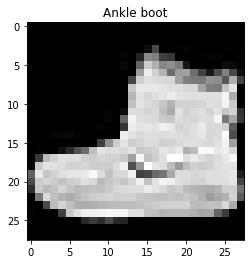

torch.Size([1, 28, 28])

In [79]:
image, label = train_data_loader.dataset[0]
plt.imshow(image.squeeze(),cmap='gray')
plt.title(train_data_loader.dataset.classes[label])
plt.show()
image.shape

torch.Size([1, 9, 27, 27])

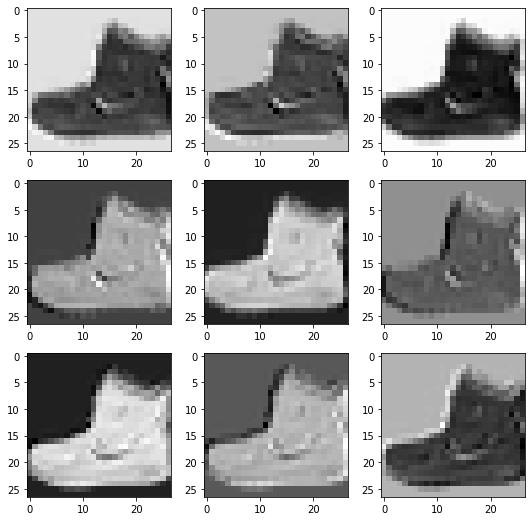

In [80]:
p = nn.Conv2d(in_channels=1,
              out_channels=9,
              kernel_size=2)
# q = nn.ReLU()
# r = nn.Conv2d(in_channels=9,
#               out_channels=9,
#               kernel_size=(5,5))
y = p(image.unsqueeze(0))
plt.figure(figsize=(9,9))
for i in range(1,10):
    plt.subplot(3,3,i)
    plt.imshow(y[0][i-1].detach(),cmap='gray')
y.shape

In [81]:
result = model1(image.unsqueeze(0).to(device))
result

tensor([[-0.1328,  0.0176, -0.1887, -0.1446, -0.1714,  0.2265,  0.1461, -0.2864,
         -0.1744,  0.0344]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [82]:
## Picking a loss function, evalution function and optimizer

def accuracy_fn(y_pred, y_true):
    return (y_pred==y_true).sum().item() / len(y_pred)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.1)


In [83]:
def training_step(model:torch.nn.Module,
             data_loader:torch.utils.data.DataLoader,
             loss_fn:torch.nn.Module,
             accuracy_fn,
             optimizer:torch.optim.Optimizer,
             device:torch.device = device):
    
    model = model.to(device)
    model.train()

    train_loss = 0
    train_acc = 0

    for batch, (X_train, y_train) in enumerate(data_loader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        train_loss += loss
        acc = accuracy_fn(y_pred=y_pred.argmax(dim=1), y_true=y_train)
        train_acc += acc
        model.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    print(f"Train loss: {train_loss:.5f} accuracy: {train_acc*100:.3f}%")


def testing_step(model:torch.nn.Module,
             data_loader:torch.utils.data.DataLoader,
             loss_fn:torch.nn.Module,
             accuracy_fn,
             device:torch.device = device):
    
    model = model.to(device)
    model.eval()

    test_loss = 0
    test_acc = 0

    with torch.inference_mode():    
        for X_test, y_test in data_loader:
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_pred = model(X_test)
            loss = loss_fn(y_pred, y_test)
            test_loss += loss
            acc = accuracy_fn(y_pred=y_pred.argmax(dim=1), y_true=y_test)
            test_acc += acc

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

    print(f"Test loss: {test_loss:.5f} accuracy: {test_acc*100:.3f}%")


def accuracy_fn(y_pred, y_true):
    return (y_pred==y_true).sum().item() / len(y_pred)

In [84]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = default_timer()

epochs = 10

for epoch in tqdm(range(epochs)):
    print(f"--------------------------------------------------{epoch}--------------------------------------------------------")
    training_step(model=model1,
                  data_loader=train_data_loader,
                  loss_fn=loss_fn,
                  accuracy_fn=accuracy_fn,
                  optimizer=optimizer,
                  device=device)
    testing_step(model=model1,
                 data_loader=test_data_loader,
                 loss_fn=loss_fn,
                 accuracy_fn=accuracy_fn,
                 device=device)

end_time = default_timer()

total_train_time = end_time - start_time
print(f"Total train time taken is {total_train_time} using device {device}")

  0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------------------------0--------------------------------------------------------
Train loss: 0.69804 accuracy: 73.743%
Test loss: 0.39199 accuracy: 85.813%
--------------------------------------------------1--------------------------------------------------------
Train loss: 0.35654 accuracy: 86.983%
Test loss: 0.34670 accuracy: 87.550%
--------------------------------------------------2--------------------------------------------------------
Train loss: 0.31440 accuracy: 88.657%
Test loss: 0.32366 accuracy: 88.578%
--------------------------------------------------3--------------------------------------------------------
Train loss: 0.29136 accuracy: 89.368%
Test loss: 0.30869 accuracy: 88.888%
--------------------------------------------------4--------------------------------------------------------
Train loss: 0.27813 accuracy: 89.860%
Test loss: 0.30484 accuracy: 89.048%
--------------------------------------------------5----------------------------------

In [85]:
# Just an audio alarm that informs if colab finished executing. 
from google.colab import output
output.eval_js('new Audio("https://upload.wikimedia.org/wikipedia/commons/5/5c/Alarm_clock_-_01.ogg").play()')